# 1. Load Strategy Returns

In [71]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:

import pandas as pd

In [73]:
import sys, os
sys.path.insert(0, os.path.abspath(".."))

In [74]:
from src.performance import (
    annualized_returns, annualized_volatility,
    sharpe_ratio, max_drawdown,
    capm_regression, bootstrap_alpha
)

In [75]:
import matplotlib.pyplot as plt
import yfinance as yf

# 1 Load the Returns

In [76]:
strat = pd.read_csv("../data/cleaned/strategy_monthly_returns.csv", 
                    index_col=0, 
                    parse_dates=True).iloc[:, 0]

# 2. Compute core metrics

In [77]:
ann_ret = annualized_returns(strat)
ann_vol = annualized_volatility(strat)
sr      = sharpe_ratio(strat, rf_rate=0.02)
mdd     = max_drawdown(strat)

print(f"Annualized Return:     {ann_ret:.2%}")
print(f"Annualized Volatility: {ann_vol:.2%}")
print(f"Sharpe Ratio (2% rf):  {sr:.2f}")
print(f"Max Drawdown:          {mdd:.2%}")

Annualized Return:     -0.52%
Annualized Volatility: 6.65%
Sharpe Ratio (2% rf):  -0.37
Max Drawdown:          42.39%


# 3. Downlaod benchmark (SPY) and compute its returns

In [78]:
spy = yf.download("SPY", start="2005-01-01", end="2024-12-31", 
                  interval="1mo")["Close"]
spy_rets = spy.pct_change().dropna().iloc[:, 0]

/tmp/ipykernel_73180/3507717611.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy = yf.download("SPY", start="2005-01-01", end="2024-12-31",
[*********************100%***********************]  1 of 1 completed


# Plot Equity Curve

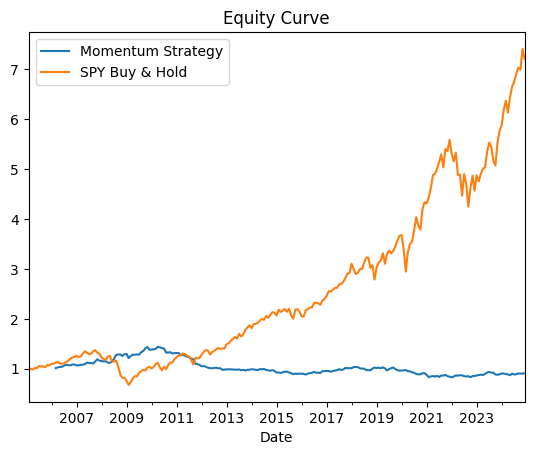

In [79]:
plt.figure()
(1 + strat).cumprod().plot(label="Momentum Strategy")
(1 + spy_rets).cumprod().plot(label="SPY Buy & Hold")
plt.legend()
plt.title("Equity Curve")
plt.savefig("../figures/equity_curve.png")

# Plot Drawdown

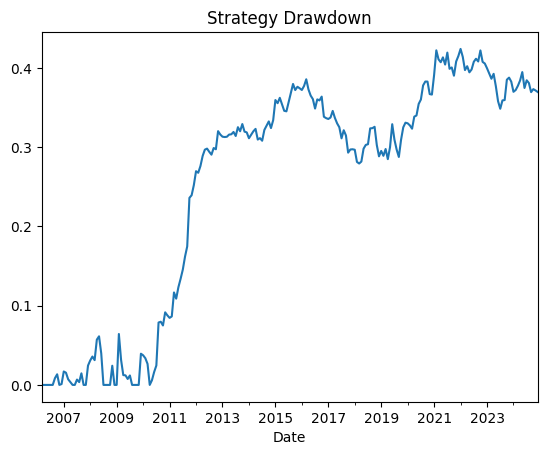

In [80]:
wealth = (1+strat).cumprod()
peak = wealth.cummax()
drawdown = (peak-wealth)/peak

plt.figure()
drawdown.plot()
plt.title("Strategy Drawdown")
plt.savefig("../figures/drawdown.png")

# CAPM Regression

In [82]:
common_idx = strat.index.intersection(spy_rets.index)

strat_aligned = strat.loc[common_idx]
sp_aligned = spy_rets.loc[common_idx]

capm = capm_regression(strat_aligned, sp_aligned, rf_rate=0.02)
print(capm.summary())

                            OLS Regression Results                            
Dep. Variable:                      0   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.215
Date:                Sun, 13 Jul 2025   Prob (F-statistic):              0.272
Time:                        21:31:54   Log-Likelihood:                 573.90
No. Observations:                 226   AIC:                            -1144.
Df Residuals:                     224   BIC:                            -1137.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0021      0.001     -1.654      0.1

# Bootstrap Test

In [84]:
alpha, p_val=bootstrap_alpha(strat_aligned, sp_aligned, rf_rate=0.02, n_iters=1000, seed=42)
print(f"Bootstrap alpha: {alpha:.4%}, p-value: {p_val:.3f}")

Bootstrap alpha: -0.2141%, p-value: 0.501


In [ ]:
print(type(strat), strat.shape)

In [ ]:
print(type(spy_rets), spy_rets.shape)